In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import cython
%matplotlib inline

In [2]:
eps = 0.01
pc_ini = .5
bs_ini = np.linspace(9/8, 3/2, num=30) + eps
bs = np.array([bs_ini[0], bs_ini[1], bs_ini[2], bs_ini[3], bs_ini[4], bs_ini[6], bs_ini[7], bs_ini[9], bs_ini[10], bs_ini[16], bs_ini[17], bs_ini[-2], bs_ini[-1]])
seeds = np.array([i for i in range(1, 6)])
n = len(seeds)
m = len(bs)
L = 60
evol = 1000

In [3]:
""" Tabulate neighbors """
NUM_NEIGHB = 9

def get_site(coord, L):
    """Get the site index from the 3-vector of coordinates."""
    # XXX: 3D hardcoded, can do N-D
    return coord[0] * L[1] + coord[1]


def get_coord(site, L):
    """Get the 3-vector of coordinates from the site index."""
    # XXX: 3D hardcoded, can do N-D
    x = site // L[1]
    y = site % L[1]
    return [x, y]


def get_neighbors(site, L):
    neighb = set()
    x, y = get_coord(site, L)
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            x1 = (x + i) % L[0]
            y1 = (y + j) % L[1]
            neighb.add(get_site([x1, y1], L))
    
    return list(neighb)
    
def tabulate_neighbors(L):
    """Tabulate the root-2 neighbors on the 3D cubic lattice with PBC."""
    Nsite = L[0]*L[1]
    neighb = np.empty((Nsite, NUM_NEIGHB), dtype=int)
    for site in range(Nsite):
        neighb[site, :] = get_neighbors(site, L)
    return neighb

def CSR_neigbours(L):
    """ Tabulate neigbors in Compressed Sparse Row format"""
    R = np.zeros(L[0] * L[1] + 1, int)
    C = np.zeros(L[0] * L[1] * NUM_NEIGHB * 2, int)
    for i in range(R.shape[0] - 1):
        R[i + 1] = R[i] + NUM_NEIGHB
        C[R[i] : R[i + 1]] = get_neighbors(i, L)
    return R, C

In [4]:
%load_ext cython

In [5]:
%%cython --annotate
import cython
import numpy as np
from rndm_wrapper cimport RndmWrapper
@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def evolve_C_2(field_orig, int[:, :] neighbors, double b, int steps, int seed):
    '''
    ---Эволюция поля на Cython с RndmWrapper---
    
    принимает на вход
    - field - поле
    - b - коэффициент выигрыша
    - steps - количество шагов эволюции. За один шаг происходит эволюция одного случайного агента
    
    -------------------
    '''
    
    # обьявление переменных
    
    cdef int [:] field = field_orig.flatten() # переводим двумерный массив в одномерный
    
    cdef int N_NEIGHBR = neighbors.shape[1]
    
    cdef int step, x, n_id, j, y
    
    cdef int L = field.shape[0]
    
    cdef double scorex, scorey
    
    cdef RndmWrapper rndm = RndmWrapper(seed=(seed, 0))
    
    for step in range(steps):
        scorex = 0
        x = int(rndm.uniform() * L)
        for n_id in range(N_NEIGHBR):
            if field[neighbors[x, n_id]] == 0:
                scorex += 1
        if field[x] == 1:
            scorex *= b
        
        scorey = 0
        y = int(rndm.uniform() * N_NEIGHBR)
        y = neighbors[x, y]
        for n_id in range(N_NEIGHBR):
                if field[neighbors[y, n_id]] == 0:
                    scorey += 1
        if field[y] == 1:
            scorey *= b
        if scorey > scorex:
            field[x] = field[y]
    SHAPE = field_orig.shape
    field_orig = np.array(field)
    return np.reshape(field_orig, SHAPE)

In [6]:
def make_field(size, pc_initial):
    '''
    ---Формирование поля для одного seed---
    
    принимает на вход
    - size - размер поля
    - pc_initial - начальная плотность кооператоров
    
    возвращает
    - field - поле по заданным начальным условиям, где 1 - дефектор, 0 - кооператор
    
    ---------------------------------------
    '''
    field = np.array(np.random.rand(size, size) > pc_initial, dtype=int)
    return field
            
def calculate_pc(size, pc_initial, b, evol_steps, seed):
    '''
    ---Вычисление плотности кооператоров---
    
    принимает на вход
    - size
    - pc_initial
    - b
    - evol_steps - шаги эволюции
    - seed - начальное условие генератора для повторяемости результата
    
    возвращает
    - pc - плотность кооператоров на протяжении evol_steps шагов
    
    ---------------------------------------
    '''
    np.random.seed(seed)
    pc = np.zeros(evol_steps + 1)
    field = make_field(size, pc_initial)
    pc[0] = np.count_nonzero(field - 1) / (size * size)
    neighbors = tabulate_neighbors((size, size))
    for step in range(evol_steps):
        field = make_field(size, pc_initial)
        field = evolve_C_2(field, neighbors, b, (step + 1) * size * size, seed)
        pc[step + 1] = np.count_nonzero(field - 1) / (size * size)
    
    return pc

In [7]:
pc1 = np.zeros((m, evol + 1))
for i in range(m):
    pc1[i] = calculate_pc(L, pc_ini, bs[i], evol, seeds[0])
    print('\n', i, '\n-----', sep='')


0
-----

1
-----

2
-----

3
-----

4
-----

5
-----

6
-----

7
-----

8
-----

9
-----

10
-----

11
-----

12
-----


In [8]:
pc2 = np.zeros((m, evol + 1))
for i in range(m):
    pc2[i] = calculate_pc(L, pc_ini, bs[i], evol, seeds[1])
    print('\n', i, '\n-----', sep='')


0
-----

1
-----

2
-----

3
-----

4
-----

5
-----

6
-----

7
-----

8
-----

9
-----

10
-----

11
-----

12
-----


In [9]:
pc3 = np.zeros((m, evol + 1))
for i in range(m):
    pc3[i] = calculate_pc(L, pc_ini, bs[i], evol, seeds[2])
    print('\n', i, '\n-----', sep='')


0
-----

1
-----

2
-----

3
-----

4
-----

5
-----

6
-----

7
-----

8
-----

9
-----

10
-----

11
-----

12
-----


In [10]:
pc4 = np.zeros((m, evol + 1))
for i in range(m):
    pc4[i] = calculate_pc(L, pc_ini, bs[i], evol, seeds[3])
    print('\n', i, '\n-----', sep='')


0
-----

1
-----

2
-----

3
-----

4
-----

5
-----

6
-----

7
-----

8
-----

9
-----

10
-----

11
-----

12
-----


In [11]:
pc5 = np.zeros((m, evol + 1))
for i in range(m):
    pc5[i] = calculate_pc(L, pc_ini, bs[i], evol, seeds[4])
    print('\n', i, '\n-----', sep='')


0
-----

1
-----

2
-----

3
-----

4
-----

5
-----

6
-----

7
-----

8
-----

9
-----

10
-----

11
-----

12
-----


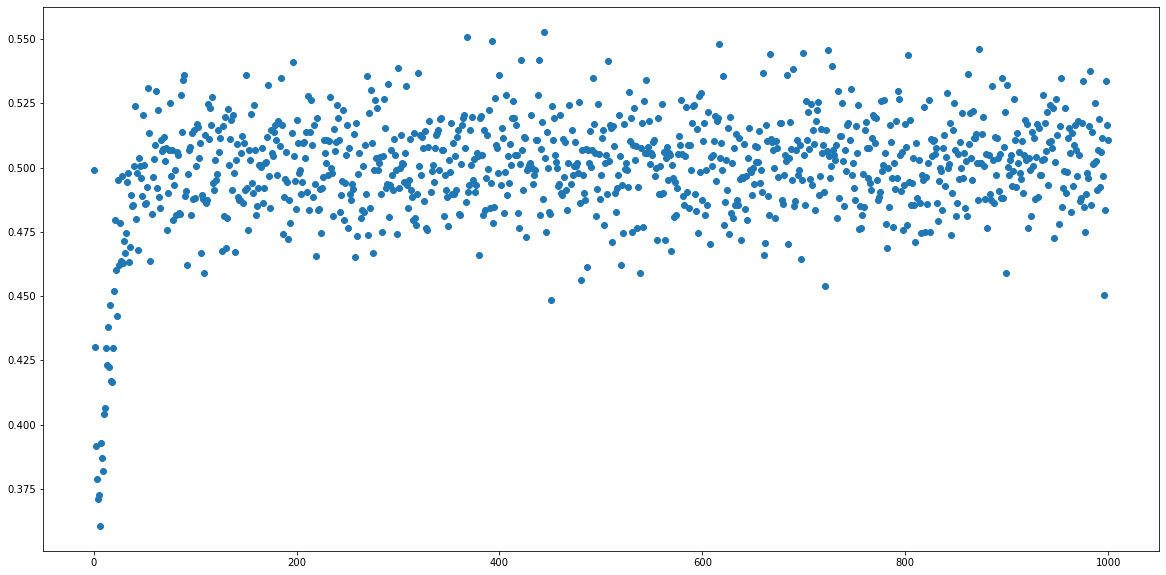

In [26]:
#График зависимости плотности от b
fig,ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(pc5[5], 'o')

In [31]:
pc60 = np.zeros((m, evol + 1))
err60 = np.zeros(m)
p_tilda60 = np.zeros(m)
for i in range(m):
    pc_temp = np.zeros((n, evol + 1))
    for j in range(n):
        pc_temp[j] = pc_t[j][i]
    pc60[i] = np.mean(pc_temp, axis=0)
    
    p_j = np.mean(pc_temp, axis=1)
    p_tilda60[i] = np.mean(pc_temp)
    err60[i] = np.sqrt((sum(p_j - p_tilda60[i]) ** 2) / n) / np.sqrt(n)
    print('\n', i, '\n-----', sep='')


0
-----

1
-----

2
-----

3
-----

4
-----

5
-----

6
-----

7
-----

8
-----

9
-----

10
-----

11
-----

12
-----


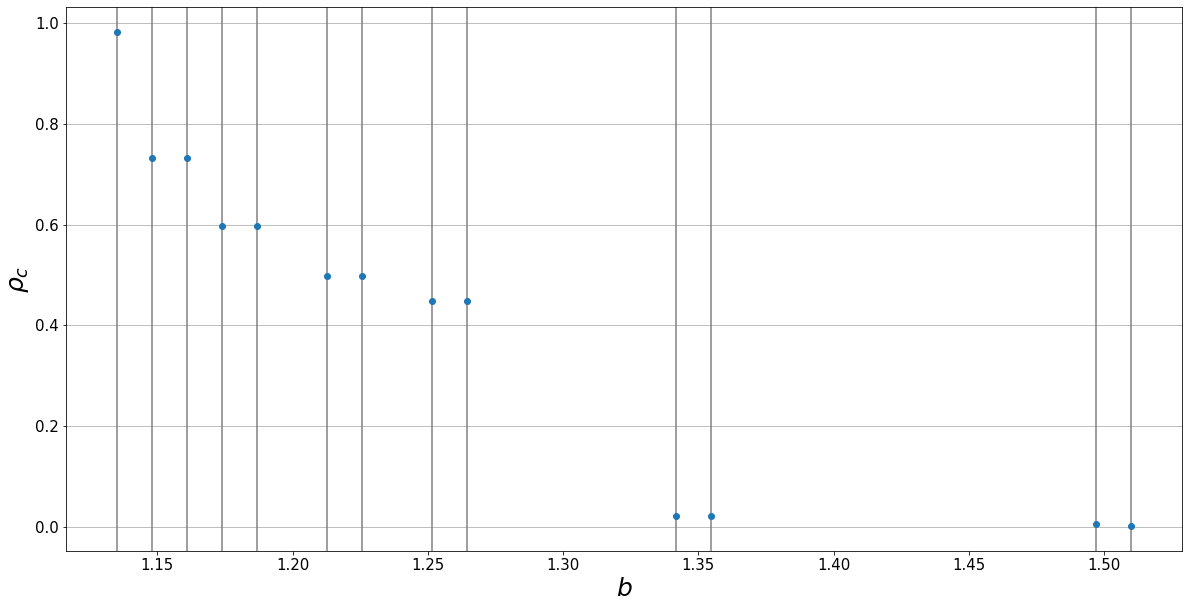

In [34]:
#График зависимости плотности от b
fig,ax = plt.subplots(1, 1, figsize=(20, 10))
ax.errorbar(bs, p_tilda60, err60, fmt='o', capsize=3)
ax.set_xlabel('$%s$'%'b',fontsize=25)
ax.set_ylabel('$%s$'%'\\rho_c',fontsize=25)
for i in range(m):
    ax.axvline(bs[i], color='grey')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(b=True,axis='y')